In [238]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from numpy.lib.stride_tricks import sliding_window_view
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from copy import deepcopy
import torch.nn.functional as F

### Preprocessing

In [142]:
canopInt = pd.read_csv('CanopInt_inst_data.csv')
lat_lon = pd.read_csv('country_latitude_longitude_area_lookup.csv')
esoil = pd.read_csv('ESoil_tavg_data.csv')
landcover = pd.read_csv('Land_cover_percent_data.csv')
rainf = pd.read_csv('Rainf_tavg_data.csv')
snow = pd.read_csv('Snowf_tavg_data.csv')
soilMoi0_10 = pd.read_csv('SoilMoi0_10cm_inst_data.csv')
soilMoi10_40 = pd.read_csv('SoilMoi10_40cm_inst_data.csv')
soilMoi100_200 = pd.read_csv('SoilMoi100_200cm_inst_data.csv')
soilMoi40_100 = pd.read_csv('SoilMoi40_100cm_inst_data.csv')
soilTMP0_10 = pd.read_csv('SoilTMP0_10cm_inst_data.csv')
soilTMP10_40 = pd.read_csv('SoilTMP10_40cm_inst_data.csv')
soilTMP100_200 = pd.read_csv('SoilTMP100_200cm_inst_data.csv')
soilTMP40_100 = pd.read_csv('SoilTMP40_100cm_inst_data.csv')
TVeg = pd.read_csv('TVeg_tavg_data.csv')
TWS = pd.read_csv('TWS_inst_data.csv')
Yield_and_Production = pd.read_csv('Yield_and_Production_data.csv')

In [143]:
canopInt['Avg_CanopInt_inst']=np.mean(canopInt.iloc[:,2:-1],axis=1)
canopInt=canopInt[['latitude','longitude','year','Avg_CanopInt_inst']]
esoil['Avg_ESoil_tavg']=np.mean(esoil.iloc[:,2:-1],axis=1)
esoil=esoil[['latitude','longitude','year','Avg_ESoil_tavg']]
rainf['Avg_Rainf_tavg']=np.mean(rainf.iloc[:,2:-1],axis=1)
rainf=rainf[['latitude','longitude','year','Avg_Rainf_tavg']]
snow['Avg_Snowf_tavg']=np.mean(snow.iloc[:,2:-1],axis=1)
snow=snow[['latitude','longitude','year','Avg_Snowf_tavg']]
soilMoi0_10['Avg_SoilMoi0_10']=np.mean(soilMoi0_10.iloc[:,2:-1],axis=1)
soilMoi0_10=soilMoi0_10[['latitude','longitude','year','Avg_SoilMoi0_10']]
soilMoi10_40['Avg_SoilMoi10_40']=np.mean(soilMoi10_40.iloc[:,2:-1],axis=1)
soilMoi10_40=soilMoi10_40[['latitude','longitude','year','Avg_SoilMoi10_40']]
soilMoi100_200['Avg_SoilMoi100_200']=np.mean(soilMoi100_200.iloc[:,2:-1],axis=1)
soilMoi100_200=soilMoi100_200[['latitude','longitude','year','Avg_SoilMoi100_200']]
soilMoi40_100['Avg_SoilMoi40_100']=np.mean(soilMoi40_100.iloc[:,2:-1],axis=1)
soilMoi40_100=soilMoi40_100[['latitude','longitude','year','Avg_SoilMoi40_100']]
soilTMP0_10['Avg_SoilTMP0_10']=np.mean(soilTMP0_10.iloc[:,2:-1],axis=1)
soilTMP0_10=soilTMP0_10[['latitude','longitude','year','Avg_SoilTMP0_10']]
soilTMP10_40['Avg_SoilTMP10_40']=np.mean(soilTMP10_40.iloc[:,2:-1],axis=1)
soilTMP10_40=soilTMP10_40[['latitude','longitude','year','Avg_SoilTMP10_40']]
soilTMP100_200['Avg_SoilTMP100_200']=np.mean(soilTMP100_200.iloc[:,2:-1],axis=1)
soilTMP100_200=soilTMP100_200[['latitude','longitude','year','Avg_SoilTMP100_200']]
soilTMP40_100['Avg_SoilTMP40_100']=np.mean(soilTMP40_100.iloc[:,2:-1],axis=1)
soilTMP40_100=soilTMP40_100[['latitude','longitude','year','Avg_SoilTMP40_100']]
TWS['Avg_TWS_inst']=np.mean(TWS.iloc[:,2:-1],axis=1)
TWS=TWS[['latitude','longitude','year','Avg_TWS_inst']]
TVeg['Avg_TVeg_tavg']=np.mean(TVeg.iloc[:,2:-1],axis=1)
TVeg=TVeg[['latitude','longitude','year','Avg_TVeg_tavg']]

In [144]:
datasets = [
    esoil, landcover, rainf, snow, soilMoi0_10, soilMoi10_40, soilMoi100_200, soilMoi40_100,
    soilTMP0_10, soilTMP10_40, soilTMP100_200, soilTMP40_100, TWS, TVeg
]

merged_cols = canopInt.copy()
for ds in datasets:
    merged_cols = pd.merge(merged_cols, ds, on=['longitude', 'latitude', 'year'], how='inner')

merged_cols = merged_cols.dropna().reset_index(drop=True)


In [145]:
lat_lon=lat_lon.dropna().reset_index(drop=True)

### Bounding Box method

In [146]:
lat_dict,long_dict={},{}
for _, row in lat_lon.iterrows():
    lat_min = row['centroid latitude'] - row['centroid radius']
    lat_max = row['centroid latitude'] + row['centroid radius']
    lon_min = row['centroid longitude'] - row['centroid radius']
    lon_max = row['centroid longitude'] + row['centroid radius']
    lat_dict[row['country']]=(lat_min,lat_max)
    long_dict[row['country']]=(lon_min,lon_max)
    
def assign_country_box(lat, lon):
    for key in lat_dict.keys():
        if lat_dict[key][0] <= lat <= lat_dict[key][1] and long_dict[key][0] <= lon <= long_dict[key][1]:
            return key
    return 'Unknown'

merged_cols['country_box'] = merged_cols.apply(lambda row: assign_country_box(row['latitude'], row['longitude']), axis=1)


In [147]:
len(merged_cols['country_box'].unique())

150

In [150]:
centroids = lat_lon[['country', 'centroid latitude', 'centroid longitude', 'area', 'centroid radius']]

### cKDTree method

In [153]:
from scipy.spatial import cKDTree
centroids = lat_lon[['centroid latitude', 'centroid longitude']].values
tree = cKDTree(centroids)
points = merged_cols[['latitude', 'longitude']].values

# Find nearest centroid for each point
distances, indices = tree.query(points)
merged_cols['country'] = lat_lon.iloc[indices]['country'].values

In [154]:
len(merged_cols['country'].unique())

194

In [160]:
merged_cols = merged_cols.drop(columns=['latitude', 'longitude'])
merged_cols = merged_cols.groupby(['country', 'year'], as_index=False).mean(numeric_only=True)

In [162]:
Yield_and_Production=Yield_and_Production[Yield_and_Production.Element=='Yield'].reset_index(drop=True)
Yield_and_Production=Yield_and_Production[['Country','Item','Year','Value']]
Yield_and_Production = Yield_and_Production.rename(columns={
    'Country': 'country',
    'Year': 'year',
    'Value': 'yield_value' 
})

In [164]:
merged_cols = pd.merge(merged_cols,Yield_and_Production, on=['country', 'year'])

### Model 1: LSTM (Optional can be skipped)

In [389]:
df = deepcopy(merged_cols)

In [391]:
le = LabelEncoder()
df['item_id'] = le.fit_transform(df['Item'])

In [393]:
def make_panel_sequences_default(df, feature_cols, target_col, seq_len=3):
    # 1) Sort once by panel key and time
    df = df.sort_values(['country','item_id','year'], ignore_index=True)
    
    X_list = []
    y_list = []
    
    # 2) Build sequences per (country, item_id)
    grouped = df.groupby(['country','item_id'], sort=False)
    for (_, _), panel in grouped:
        arr = panel[feature_cols + [target_col]].to_numpy()
        n_rows, n_cols = arr.shape
        
        # need at least seq_len + 1 years to make one sample
        if n_rows <= seq_len:
            continue
        
        # 3) Vectorized sliding window along rows
        #    windows shape: (n_rows - seq_len, seq_len+1, n_cols)
        windows = sliding_window_view(arr, window_shape=(seq_len+1, n_cols))
        # but numpy.view with 2D window gives extra axis, so simplify:
        windows = windows.squeeze(1)
        
        # 4) Split into X (first seq_len rows) and y (last row's target)
        Xc = windows[:, :seq_len, :-1]
        yc = windows[:,  seq_len,   -1]
        
        X_list.append(Xc)
        y_list.append(yc)
    
    # 5) Concatenate all panels
    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)
    return X_all, y_all

In [395]:
[
    c for c in df.columns
    if c not in ['latitude','longitude','Item','yield_value','country','year']
]

['Avg_CanopInt_inst',
 'Avg_ESoil_tavg',
 'Land_cover_percent_class_1',
 'Land_cover_percent_class_2',
 'Land_cover_percent_class_3',
 'Land_cover_percent_classh_4',
 'Land_cover_percent_class_5',
 'Land_cover_percent_class_6',
 'Land_cover_percent_class_7',
 'Land_cover_percent_class_8',
 'Land_cover_percent_class_9',
 'Land_cover_percent_class_10',
 'Land_cover_percent_class_11',
 'Land_cover_percent_class_12',
 'Land_cover_percent_class_13',
 'Land_cover_percent_class_14',
 'Land_cover_percent_class_15',
 'Land_cover_percent_class_16',
 'Land_cover_percent_class_17',
 'Avg_Rainf_tavg',
 'Avg_Snowf_tavg',
 'Avg_SoilMoi0_10',
 'Avg_SoilMoi10_40',
 'Avg_SoilMoi100_200',
 'Avg_SoilMoi40_100',
 'Avg_SoilTMP0_10',
 'Avg_SoilTMP10_40',
 'Avg_SoilTMP100_200',
 'Avg_SoilTMP40_100',
 'Avg_TWS_inst',
 'Avg_TVeg_tavg',
 'item_id']

In [397]:
seq_len = 3
X_scaler = StandardScaler()
y_scaler = StandardScaler()

feature_cols = [
    c for c in df.columns
    if c not in ['latitude','longitude','Item','yield_value','country','year']
]

# Scale feature matrix and target vector
df[feature_cols] = X_scaler.fit_transform(df[feature_cols])
df['Value_scaled'] = y_scaler.fit_transform(df[['yield_value']])
feature_cols = [
    c for c in df.columns
    if c not in ['latitude','longitude','Item','yield_value','country','year','Value_scaled']
]

X, y = make_panel_sequences_default(df, feature_cols, 'Value_scaled', seq_len)

print("X.shape:", X.shape)  # → (total_sequences, seq_len, num_features)
print("y.shape:", y.shape)

X.shape: (51613, 3, 32)
y.shape: (51613,)


### Train Validation splitting

In [398]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [399]:
class PanelLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers>1 else 0)
        self.fc   = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)         # out: (batch, seq_len, hidden_size)
        last = out[:, -1, :]          # last timestep
        return self.fc(last).squeeze()  # (batch,)

### Training and Validation

In [400]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Create DataLoader
batch_size = 64
train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

# Validation loader
val_ds = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)
# 3. Instantiate model, loss, optimizer
model = PanelLSTM(input_size=X.shape[2], hidden_size=64, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# 4. Training
n_epochs = 100
for epoch in range(1, n_epochs+1):
    # ——— Training ———
    model.train()
    train_loss = 0.0
    all_preds = []
    all_targets = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        all_preds.append(preds.detach().cpu())
        all_targets.append(yb.detach().cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Calculate train loss using the whole dataset
    train_loss = F.mse_loss(all_preds, all_targets, reduction='mean').item()

    # Calculate R² score
    train_r2 = r2_score(all_targets.numpy(), all_preds.numpy())
    
    # ——— Validation ———
    all_preds = []
    all_targets = []
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            all_preds.append(preds.detach().cpu())
            all_targets.append(yb.detach().cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Calculate train loss using the whole dataset
    val_loss = F.mse_loss(all_preds, all_targets, reduction='mean').item()

    # Calculate R² score
    val_r2 = r2_score(all_targets.numpy(), all_preds.numpy())
    
    # ——— Logging ———
    print(f"Epoch {epoch:03d} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} ,Train R2 score: {train_r2:.4f}, Val R2 score: {val_r2:.4f}")

C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 001 — Train Loss: 0.9540, Val Loss: 0.9312 ,Train R2 score: 0.0498, Val R2 score: 0.0571


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 002 — Train Loss: 0.9338, Val Loss: 0.9159 ,Train R2 score: 0.0698, Val R2 score: 0.0726


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 003 — Train Loss: 0.9234, Val Loss: 0.9093 ,Train R2 score: 0.0803, Val R2 score: 0.0793


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 004 — Train Loss: 0.9141, Val Loss: 0.9186 ,Train R2 score: 0.0895, Val R2 score: 0.0698


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 005 — Train Loss: 0.9080, Val Loss: 0.8989 ,Train R2 score: 0.0955, Val R2 score: 0.0897


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 006 — Train Loss: 0.9042, Val Loss: 0.8985 ,Train R2 score: 0.0994, Val R2 score: 0.0902


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 007 — Train Loss: 0.8988, Val Loss: 0.8928 ,Train R2 score: 0.1047, Val R2 score: 0.0959


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 008 — Train Loss: 0.8966, Val Loss: 0.8936 ,Train R2 score: 0.1069, Val R2 score: 0.0952


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 009 — Train Loss: 0.8920, Val Loss: 0.8796 ,Train R2 score: 0.1115, Val R2 score: 0.1093


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 010 — Train Loss: 0.8891, Val Loss: 0.8801 ,Train R2 score: 0.1144, Val R2 score: 0.1088


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 011 — Train Loss: 0.8868, Val Loss: 0.8788 ,Train R2 score: 0.1167, Val R2 score: 0.1101


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 012 — Train Loss: 0.8828, Val Loss: 0.8789 ,Train R2 score: 0.1206, Val R2 score: 0.1100


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 013 — Train Loss: 0.8822, Val Loss: 0.8767 ,Train R2 score: 0.1212, Val R2 score: 0.1122


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 014 — Train Loss: 0.8764, Val Loss: 0.8726 ,Train R2 score: 0.1270, Val R2 score: 0.1164


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 015 — Train Loss: 0.8744, Val Loss: 0.8780 ,Train R2 score: 0.1290, Val R2 score: 0.1109


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 016 — Train Loss: 0.8728, Val Loss: 0.8621 ,Train R2 score: 0.1306, Val R2 score: 0.1270


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 017 — Train Loss: 0.8669, Val Loss: 0.8614 ,Train R2 score: 0.1365, Val R2 score: 0.1278


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 018 — Train Loss: 0.8671, Val Loss: 0.8712 ,Train R2 score: 0.1363, Val R2 score: 0.1178


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 019 — Train Loss: 0.8650, Val Loss: 0.8628 ,Train R2 score: 0.1384, Val R2 score: 0.1263


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 020 — Train Loss: 0.8591, Val Loss: 0.8537 ,Train R2 score: 0.1443, Val R2 score: 0.1356


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 021 — Train Loss: 0.8545, Val Loss: 0.8587 ,Train R2 score: 0.1488, Val R2 score: 0.1305


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 022 — Train Loss: 0.8535, Val Loss: 0.8447 ,Train R2 score: 0.1498, Val R2 score: 0.1447


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 023 — Train Loss: 0.8453, Val Loss: 0.8471 ,Train R2 score: 0.1581, Val R2 score: 0.1422


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 024 — Train Loss: 0.8463, Val Loss: 0.8442 ,Train R2 score: 0.1570, Val R2 score: 0.1452


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 025 — Train Loss: 0.8358, Val Loss: 0.8333 ,Train R2 score: 0.1675, Val R2 score: 0.1562


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 026 — Train Loss: 0.8287, Val Loss: 0.8127 ,Train R2 score: 0.1745, Val R2 score: 0.1770


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 027 — Train Loss: 0.8089, Val Loss: 0.7879 ,Train R2 score: 0.1942, Val R2 score: 0.2022


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 028 — Train Loss: 0.7956, Val Loss: 0.7613 ,Train R2 score: 0.2075, Val R2 score: 0.2291


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 029 — Train Loss: 0.7819, Val Loss: 0.7742 ,Train R2 score: 0.2212, Val R2 score: 0.2161


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 030 — Train Loss: 0.7518, Val Loss: 0.8750 ,Train R2 score: 0.2511, Val R2 score: 0.1140


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 031 — Train Loss: 0.8041, Val Loss: 0.7644 ,Train R2 score: 0.1991, Val R2 score: 0.2260


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 032 — Train Loss: 0.7380, Val Loss: 0.7300 ,Train R2 score: 0.2649, Val R2 score: 0.2608


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 033 — Train Loss: 0.7192, Val Loss: 0.6747 ,Train R2 score: 0.2837, Val R2 score: 0.3168


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 034 — Train Loss: 0.7076, Val Loss: 0.7098 ,Train R2 score: 0.2952, Val R2 score: 0.2813


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 035 — Train Loss: 0.6705, Val Loss: 0.6529 ,Train R2 score: 0.3321, Val R2 score: 0.3389


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 036 — Train Loss: 0.6875, Val Loss: 0.6853 ,Train R2 score: 0.3152, Val R2 score: 0.3061


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 037 — Train Loss: 0.6749, Val Loss: 0.6709 ,Train R2 score: 0.3277, Val R2 score: 0.3207


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 038 — Train Loss: 0.6812, Val Loss: 0.6459 ,Train R2 score: 0.3215, Val R2 score: 0.3460


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 039 — Train Loss: 0.6687, Val Loss: 0.6973 ,Train R2 score: 0.3339, Val R2 score: 0.2939


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 040 — Train Loss: 0.6447, Val Loss: 0.6870 ,Train R2 score: 0.3579, Val R2 score: 0.3044


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 041 — Train Loss: 0.6441, Val Loss: 0.6364 ,Train R2 score: 0.3584, Val R2 score: 0.3556


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 042 — Train Loss: 0.6284, Val Loss: 0.6249 ,Train R2 score: 0.3741, Val R2 score: 0.3672


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 043 — Train Loss: 0.6234, Val Loss: 0.5961 ,Train R2 score: 0.3790, Val R2 score: 0.3964


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 044 — Train Loss: 0.6326, Val Loss: 0.6564 ,Train R2 score: 0.3699, Val R2 score: 0.3354


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 045 — Train Loss: 0.6274, Val Loss: 0.5957 ,Train R2 score: 0.3751, Val R2 score: 0.3968


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 046 — Train Loss: 0.6266, Val Loss: 0.6323 ,Train R2 score: 0.3758, Val R2 score: 0.3598


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 047 — Train Loss: 0.6193, Val Loss: 0.5985 ,Train R2 score: 0.3831, Val R2 score: 0.3940


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 048 — Train Loss: 0.6345, Val Loss: 0.5977 ,Train R2 score: 0.3679, Val R2 score: 0.3947


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 049 — Train Loss: 0.5936, Val Loss: 0.5860 ,Train R2 score: 0.4087, Val R2 score: 0.4067


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 050 — Train Loss: 0.6217, Val Loss: 0.5758 ,Train R2 score: 0.3807, Val R2 score: 0.4169


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 051 — Train Loss: 0.5965, Val Loss: 0.5753 ,Train R2 score: 0.4059, Val R2 score: 0.4174


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 052 — Train Loss: 0.6065, Val Loss: 0.6388 ,Train R2 score: 0.3959, Val R2 score: 0.3532


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 053 — Train Loss: 0.6271, Val Loss: 0.6179 ,Train R2 score: 0.3753, Val R2 score: 0.3743


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 054 — Train Loss: 0.6000, Val Loss: 0.5949 ,Train R2 score: 0.4024, Val R2 score: 0.3976


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 055 — Train Loss: 0.6061, Val Loss: 0.5805 ,Train R2 score: 0.3963, Val R2 score: 0.4122


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 056 — Train Loss: 0.5828, Val Loss: 0.6483 ,Train R2 score: 0.4195, Val R2 score: 0.3436


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 057 — Train Loss: 0.5749, Val Loss: 0.6968 ,Train R2 score: 0.4274, Val R2 score: 0.2945


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 058 — Train Loss: 0.5747, Val Loss: 0.5478 ,Train R2 score: 0.4276, Val R2 score: 0.4453


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 059 — Train Loss: 0.5923, Val Loss: 0.5885 ,Train R2 score: 0.4100, Val R2 score: 0.4041


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 060 — Train Loss: 0.5783, Val Loss: 0.5593 ,Train R2 score: 0.4239, Val R2 score: 0.4337


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 061 — Train Loss: 0.5511, Val Loss: 0.5390 ,Train R2 score: 0.4510, Val R2 score: 0.4542


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 062 — Train Loss: 0.5633, Val Loss: 0.5954 ,Train R2 score: 0.4389, Val R2 score: 0.3971


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 063 — Train Loss: 0.5818, Val Loss: 0.5659 ,Train R2 score: 0.4205, Val R2 score: 0.4270


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 064 — Train Loss: 0.5735, Val Loss: 0.5642 ,Train R2 score: 0.4287, Val R2 score: 0.4287


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 065 — Train Loss: 0.5473, Val Loss: 0.5942 ,Train R2 score: 0.4548, Val R2 score: 0.3983


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 066 — Train Loss: 0.5462, Val Loss: 0.5356 ,Train R2 score: 0.4559, Val R2 score: 0.4576


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 067 — Train Loss: 0.5517, Val Loss: 0.5280 ,Train R2 score: 0.4504, Val R2 score: 0.4654


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 068 — Train Loss: 0.5673, Val Loss: 0.6048 ,Train R2 score: 0.4349, Val R2 score: 0.3876


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 069 — Train Loss: 0.5456, Val Loss: 0.5378 ,Train R2 score: 0.4565, Val R2 score: 0.4554


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 070 — Train Loss: 0.5351, Val Loss: 0.5264 ,Train R2 score: 0.4670, Val R2 score: 0.4670


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 071 — Train Loss: 0.5430, Val Loss: 0.5941 ,Train R2 score: 0.4591, Val R2 score: 0.3984


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 072 — Train Loss: 0.5601, Val Loss: 0.5274 ,Train R2 score: 0.4420, Val R2 score: 0.4660


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 073 — Train Loss: 0.5301, Val Loss: 0.6141 ,Train R2 score: 0.4719, Val R2 score: 0.3782


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 074 — Train Loss: 0.5394, Val Loss: 0.5460 ,Train R2 score: 0.4627, Val R2 score: 0.4471


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 075 — Train Loss: 0.5358, Val Loss: 0.5783 ,Train R2 score: 0.4663, Val R2 score: 0.4145


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 076 — Train Loss: 0.5243, Val Loss: 0.5493 ,Train R2 score: 0.4778, Val R2 score: 0.4438


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 077 — Train Loss: 0.5257, Val Loss: 0.5190 ,Train R2 score: 0.4763, Val R2 score: 0.4745


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 078 — Train Loss: 0.5335, Val Loss: 0.5588 ,Train R2 score: 0.4686, Val R2 score: 0.4342


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 079 — Train Loss: 0.5282, Val Loss: 0.5208 ,Train R2 score: 0.4738, Val R2 score: 0.4727


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 080 — Train Loss: 0.5146, Val Loss: 0.5405 ,Train R2 score: 0.4874, Val R2 score: 0.4527


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 081 — Train Loss: 0.5274, Val Loss: 0.5088 ,Train R2 score: 0.4747, Val R2 score: 0.4848


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 082 — Train Loss: 0.5503, Val Loss: 0.5447 ,Train R2 score: 0.4518, Val R2 score: 0.4485


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 083 — Train Loss: 0.5345, Val Loss: 0.5373 ,Train R2 score: 0.4676, Val R2 score: 0.4559


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 084 — Train Loss: 0.5051, Val Loss: 0.4974 ,Train R2 score: 0.4969, Val R2 score: 0.4964


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 085 — Train Loss: 0.5214, Val Loss: 0.4866 ,Train R2 score: 0.4806, Val R2 score: 0.5073


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 086 — Train Loss: 0.5273, Val Loss: 0.5054 ,Train R2 score: 0.4748, Val R2 score: 0.4882


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 087 — Train Loss: 0.5119, Val Loss: 0.5091 ,Train R2 score: 0.4901, Val R2 score: 0.4845


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 088 — Train Loss: 0.5134, Val Loss: 0.5136 ,Train R2 score: 0.4886, Val R2 score: 0.4799


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 089 — Train Loss: 0.5087, Val Loss: 0.5005 ,Train R2 score: 0.4933, Val R2 score: 0.4932


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 090 — Train Loss: 0.4908, Val Loss: 0.4942 ,Train R2 score: 0.5111, Val R2 score: 0.4996


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 091 — Train Loss: 0.5015, Val Loss: 0.5127 ,Train R2 score: 0.5004, Val R2 score: 0.4809


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 092 — Train Loss: 0.5016, Val Loss: 0.4699 ,Train R2 score: 0.5004, Val R2 score: 0.5242


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 093 — Train Loss: 0.4967, Val Loss: 0.5456 ,Train R2 score: 0.5053, Val R2 score: 0.4476


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 094 — Train Loss: 0.4882, Val Loss: 0.5005 ,Train R2 score: 0.5137, Val R2 score: 0.4932


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 095 — Train Loss: 0.5189, Val Loss: 0.5248 ,Train R2 score: 0.4831, Val R2 score: 0.4686


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 096 — Train Loss: 0.5044, Val Loss: 0.4892 ,Train R2 score: 0.4975, Val R2 score: 0.5047


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 097 — Train Loss: 0.4926, Val Loss: 0.5974 ,Train R2 score: 0.5093, Val R2 score: 0.3951


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 098 — Train Loss: 0.5200, Val Loss: 0.5330 ,Train R2 score: 0.4820, Val R2 score: 0.4603


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 099 — Train Loss: 0.4968, Val Loss: 0.5018 ,Train R2 score: 0.5052, Val R2 score: 0.4919
Epoch 100 — Train Loss: 0.4931, Val Loss: 0.4960 ,Train R2 score: 0.5088, Val R2 score: 0.4978


C:\Users\Koustav Bhattacharje\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### Forecasting 2023 crop yield

In [405]:
preds = []
model.eval()
with torch.no_grad():
    for (_, panel) in df.groupby(['country','item_id'], sort=False):
        panel = panel.sort_values('year').reset_index(drop=True)
        if len(panel) < seq_len: continue
        seq = panel.tail(seq_len)[feature_cols].to_numpy()
        x   = torch.tensor(seq[None,:,:], dtype=torch.float32).to(device)
        y_hat_scaled = model(x).cpu().item()
        # Invert scaling to original units
        y_hat = y_scaler.inverse_transform([[y_hat_scaled]])[0,0]
        preds.append({
            'country':   panel.loc[0,'country'],
            'item': panel.loc[0,'Item'],
            'year':      2023,
            'predicted': y_hat
        })

pd.DataFrame(preds).to_csv('forecast_2023_LSTM.csv', index=False)

### Model 2 (Multilayer Perceptron)

In [407]:
df=deepcopy(merged_cols)

In [409]:
class EmbeddedYieldMLP(nn.Module):
    def __init__(self, num_features, num_countries, num_items, embedding_dim=8, hidden_dims=[128, 64]):
        super().__init__()
        self.country_emb = nn.Embedding(num_countries, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        
        input_dim = num_features + 2 * embedding_dim  # numerical + 2 embeddings
        layers = []
        for h in hidden_dims:
            layers += [nn.Linear(input_dim, h), nn.ReLU(), nn.Dropout(0.3)]
            input_dim = h
        layers.append(nn.Linear(input_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x, country_idx, item_idx):
        country_vec = self.country_emb(country_idx)
        item_vec = self.item_emb(item_idx)
        x = torch.cat([x, country_vec, item_vec], dim=1)
        return self.model(x).squeeze()

### Feature Engineering

In [411]:
# Encode country and item globally
df['country_id'] = LabelEncoder().fit_transform(df['country'])
df['item_id'] = LabelEncoder().fit_transform(df['Item'])

num_countries = df['country_id'].nunique()
num_items = df['item_id'].nunique()

feature_cols = [
    c for c in df.columns
    if c not in ['latitude','longitude','Item','yield_value','country','year','country_id','item_id']
]
# Extract raw features and target
X_raw = df[feature_cols].values
y_raw = df['yield_value'].values.reshape(-1, 1)

print(X_raw.shape)
# Scale input features and target
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X_raw)
y_scaled = y_scaler.fit_transform(y_raw)

#Apply PCA (optional, for input compression)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(X_pca.shape)


loadings = np.abs(pca.components_)  # shape: (num_components, num_features)

# Sum of contributions across all selected components
feature_scores = loadings.sum(axis=0)

# Map to feature names
pca_importance = pd.Series(feature_scores, index=feature_cols).sort_values(ascending=True)
print("Least influential features (lowest contribution to PCA):")
print(pca_importance.head(10))

print("\n Most influential features:")
print(pca_importance.tail(20))

(67963, 31)
(67963, 16)
Least influential features (lowest contribution to PCA):
Avg_SoilMoi0_10       0.978597
Avg_TWS_inst          1.194419
Avg_SoilMoi10_40      1.277572
Avg_SoilTMP100_200    1.278823
Avg_SoilTMP0_10       1.282979
Avg_SoilTMP40_100     1.284487
Avg_SoilTMP10_40      1.293618
Avg_Rainf_tavg        1.400133
Avg_TVeg_tavg         1.502908
Avg_CanopInt_inst     1.518404
dtype: float64

 Most influential features:
Avg_SoilMoi100_200             1.594384
Avg_Snowf_tavg                 1.951739
Land_cover_percent_class_6     2.001513
Land_cover_percent_class_1     2.151088
Land_cover_percent_class_3     2.208009
Land_cover_percent_class_5     2.293696
Land_cover_percent_class_13    2.331610
Land_cover_percent_class_2     2.377601
Land_cover_percent_class_7     2.388343
Land_cover_percent_class_16    2.406375
Avg_ESoil_tavg                 2.467554
Land_cover_percent_class_10    2.469899
Land_cover_percent_class_14    2.490446
Land_cover_percent_class_15    2.550110
Land_

### Creating tensors and train validation split

In [413]:
X_tensor = torch.tensor(X_pca, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).squeeze()
country_tensor = torch.tensor(df['country_id'].values, dtype=torch.long)
item_tensor = torch.tensor(df['item_id'].values, dtype=torch.long)

# Train/test split
X_train, X_val, y_train, y_val, c_train, c_val, i_train, i_val = train_test_split(
    X_tensor, y_tensor, country_tensor, item_tensor, test_size=0.2, random_state=42
)

train_ds = TensorDataset(X_train, c_train, i_train, y_train)
val_ds = TensorDataset(X_val, c_val, i_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

### Training the model

In [429]:
model = EmbeddedYieldMLP(X_train.shape[1], num_countries, num_items)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()



for epoch in range(1,101):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    for xb, cb, ib, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb, cb, ib)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        all_preds.append(preds.detach().cpu())
        all_targets.append(yb.detach().cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Calculate train loss using the whole dataset
    train_loss = F.mse_loss(all_preds, all_targets, reduction='mean').item()

    # Calculate R² score
    train_r2 = r2_score(all_targets.numpy(), all_preds.numpy())
    
    # Validation
    model.eval()
    val_loss = 0
    rmse=0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, cb, ib, yb in val_loader:
            preds = model(xb, cb, ib)
            loss = criterion(preds, yb)
            all_preds.append(preds.detach().cpu())
            all_targets.append(yb.detach().cpu())
            
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Calculate train loss using the whole dataset
    val_loss = F.mse_loss(all_preds, all_targets, reduction='mean').item()

    # Calculate R² score
    val_r2 = r2_score(all_targets.numpy(), all_preds.numpy())

    print(f"Epoch {epoch:03d} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} ,Train R2 score: {train_r2:.4f}, Val R2 score: {val_r2:.4f}")

Epoch 001 — Train Loss: 0.6073, Val Loss: 0.5287 ,Train R2 score: 0.3743, Val R2 score: 0.5268
Epoch 002 — Train Loss: 0.3928, Val Loss: 0.4285 ,Train R2 score: 0.5953, Val R2 score: 0.6165
Epoch 003 — Train Loss: 0.3326, Val Loss: 0.3739 ,Train R2 score: 0.6574, Val R2 score: 0.6654
Epoch 004 — Train Loss: 0.3027, Val Loss: 0.3657 ,Train R2 score: 0.6882, Val R2 score: 0.6727
Epoch 005 — Train Loss: 0.2787, Val Loss: 0.3249 ,Train R2 score: 0.7129, Val R2 score: 0.7092
Epoch 006 — Train Loss: 0.2645, Val Loss: 0.3111 ,Train R2 score: 0.7275, Val R2 score: 0.7216
Epoch 007 — Train Loss: 0.2515, Val Loss: 0.2884 ,Train R2 score: 0.7409, Val R2 score: 0.7418
Epoch 008 — Train Loss: 0.2415, Val Loss: 0.2917 ,Train R2 score: 0.7512, Val R2 score: 0.7389
Epoch 009 — Train Loss: 0.2313, Val Loss: 0.2496 ,Train R2 score: 0.7617, Val R2 score: 0.7766
Epoch 010 — Train Loss: 0.2157, Val Loss: 0.2519 ,Train R2 score: 0.7777, Val R2 score: 0.7746
Epoch 011 — Train Loss: 0.2188, Val Loss: 0.2767 ,

### Forecasting 2023 crop yield

In [448]:
forecast_results = []

# Filter: use only years 2020–2022 to forecast 2023
recent_df = df[df['year'].between(2020, 2022)]

# Group by country + item
grouped = recent_df.groupby(['country', 'Item'])

for (country, item), group in grouped:
    if len(group) < 1:
        continue  # Skip if no data

    country_id = group['country_id'].iloc[0]
    item_id = group['item_id'].iloc[0]

    # Average feature values across 2020–2022
    X_recent = group[feature_cols].mean().values.reshape(1, -1)

    # Scale and PCA transform (same as during training)
    X_scaled = X_scaler.transform(X_recent)
    X_pca = pca.transform(X_scaled)

    # Convert to torch tensors
    X_tensor = torch.tensor(X_pca, dtype=torch.float32)
    country_tensor = torch.tensor([country_id], dtype=torch.long)
    item_tensor = torch.tensor([item_id], dtype=torch.long)

    # Predict
    model.eval()
    with torch.no_grad():
        pred_scaled = model(X_tensor, country_tensor, item_tensor).numpy()
        pred_yield = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).squeeze()

    # Save result
    forecast_results.append({
        'country': country,
        'item': item,
        'year': 2023,
        'forecast_value': float(pred_yield)
    })

# Final forecast DataFrame
forecast_df = pd.DataFrame(forecast_results)

# Show sample
pd.DataFrame(forecast_df).to_csv('forecast_2023_MLP.csv', index=False)

In [432]:
forecast_df[(forecast_df['country']=='Lebanon') & (forecast_df['item']== 'Apples') ]

,country,item,year,forecast_value
2664,Lebanon,Apples,2023,15580.948242


In [434]:
merged_cols[['country','Item','year','yield_value']][(merged_cols['country']=='Lebanon') & (merged_cols['Item']== 'Apples')]

,country,Item,year,yield_value
34996,Lebanon,Apples,2010,12428.9
35035,Lebanon,Apples,2011,12726.6
35074,Lebanon,Apples,2012,12669.6
35113,Lebanon,Apples,2013,12654.2
35152,Lebanon,Apples,2014,15046.3
35191,Lebanon,Apples,2015,16640.0
35230,Lebanon,Apples,2016,20785.0
35269,Lebanon,Apples,2017,18998.6
35308,Lebanon,Apples,2018,17281.3
35347,Lebanon,Apples,2019,16051.8


### Model prediction vs original forecast 

In [439]:
def forecast_3year_avg(model, df, country, item, feature_cols, X_scaler, y_scaler, pca):
    # Filter for that (country, item)
    panel_df = df[(df['country'] == country) & (df['Item'] == item)].sort_values('year')
    if len(panel_df) < 4:
        print(f"Not enough data for {country} - {item}")
        return

    country_id = panel_df['country_id'].iloc[0]
    item_id = panel_df['item_id'].iloc[0]

    years = []
    actuals = []
    forecasts = []

    all_years = sorted(panel_df['year'].unique())
    
    for i in range(3, len(all_years)):
        year = all_years[i]
        prev_years = all_years[i-3:i]  # get previous 3 years

        window_df = panel_df[panel_df['year'].isin(prev_years)]
        if len(window_df) < 3:
            continue  # skip if missing years

        # Get mean of feature values from last 3 years
        X_input = window_df[feature_cols].mean().values.reshape(1, -1)
        X_scaled = X_scaler.transform(X_input)
        X_pca = pca.transform(X_scaled)

        # Convert to tensors
        X_tensor = torch.tensor(X_pca, dtype=torch.float32)
        c_tensor = torch.tensor([country_id], dtype=torch.long)
        i_tensor = torch.tensor([item_id], dtype=torch.long)

        # Predict
        model.eval()
        with torch.no_grad():
            pred_scaled = model(X_tensor, c_tensor, i_tensor).numpy()
            pred_yield = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).squeeze()

        # Actual yield
        actual_yield = panel_df[panel_df['year'] == year]['yield_value'].values
        if len(actual_yield) == 0:
            actual_yield = np.nan
        else:
            actual_yield = actual_yield[0]

        # Store
        years.append(year)
        actuals.append(actual_yield)
        forecasts.append(pred_yield)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(years, actuals, label='Actual Yield', marker='o')
    plt.plot(years, forecasts, label='Forecasted Yield (3-year avg)', linestyle='--', marker='x')
    plt.title(f"3-Year Forecast vs Actual — {item} in {country}")
    plt.xlabel("Year")
    plt.ylabel("Yield (kg/ha)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


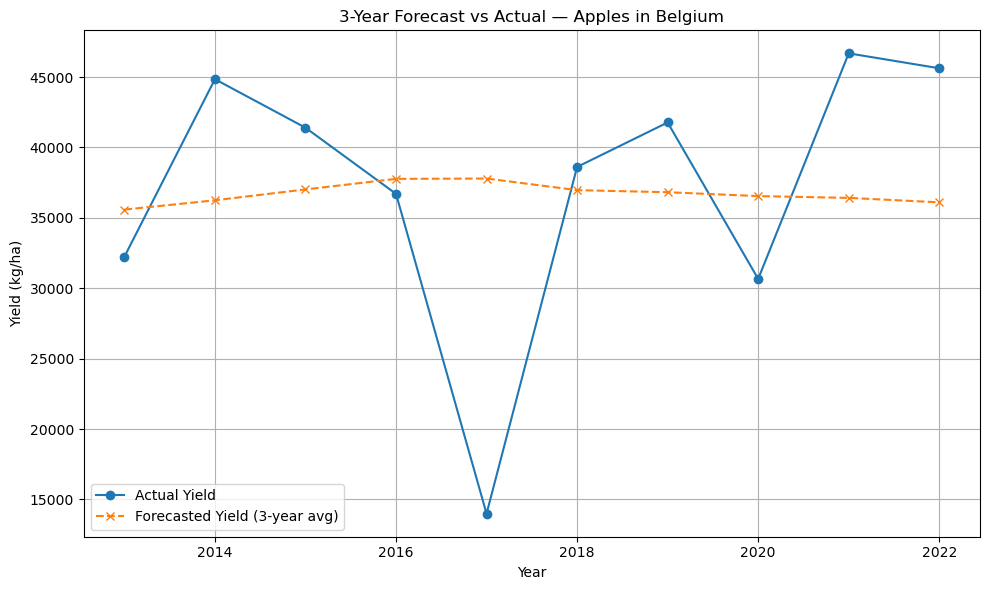

In [459]:
forecast_3year_avg(
    model=model,
    df=df,
    country='Belgium',
    item='Apples',
    feature_cols=feature_cols,
    X_scaler=X_scaler,
    y_scaler=y_scaler,
    pca=pca
)
